OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [3]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
# ...
# ...
print("a:")
print(a)
print()
print("b:")
print(b)

a:
[[0.81394873 0.13194874 0.21177084]
 [0.61361264 0.85081194 0.65123067]]

b:
tensor([[0.8139, 0.1319, 0.2118],
        [0.6136, 0.8508, 0.6512]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [10]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(A)
print(b)
print(x)

print(y)

z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.2814, 0.8671],
        [0.1726, 0.4383]])
tensor([[0.3760],
        [0.4970]])
tensor([[0.1223],
        [0.4196]], requires_grad=True)
tensor([[0.7743],
        [0.7020]], grad_fn=<AddBackward0>)
tensor(1.4763, grad_fn=<SumBackward0>)
tensor([[0.4540],
        [1.3054]])
tensor([[0.1223],
        [0.4196]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [11]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let us examine the size of the dataset.

In [105]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?
# ...
# ...
print(trainingdata)
print(testdata)
print(trainingdata.targets.shape)

print(trainingdata.data.shape)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./FashionMNIST/
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000])
torch.Size([60000, 28, 28])


Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

9


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


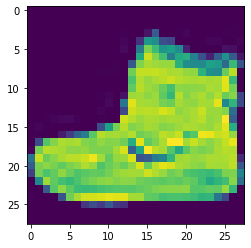

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.
# ...
# ...
print(label)
plt.imshow(image.resize(28,28))

Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [47]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([0, 8, 1, 4, 3, 0, 3, 2, 0, 0, 7, 8, 8, 5, 1, 2, 2, 9, 5, 1, 1, 9, 7, 8,
        5, 0, 3, 1, 2, 6, 7, 0, 7, 0, 5, 3, 1, 0, 9, 2, 1, 3, 8, 5, 4, 8, 5, 5,
        1, 2, 2, 4, 9, 8, 2, 0, 5, 1, 8, 0, 9, 3, 7, 8])


In [50]:
print(image.shape)

torch.Size([1, 28, 28])


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


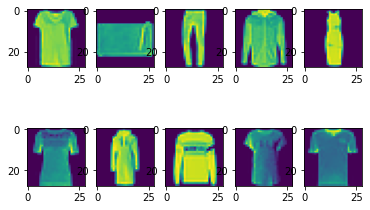

In [113]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.
# ...
# ...

for i in range(0,10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i].resize(28,28))
  

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [103]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [126]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 epochs, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.
# ...
# ...
for epoch in range(2):
  y_tr_pred = net(image)
  tr_loss = Loss(label, y_tr_pred)

  # ts_input = testdata.data
  # ts_label = testdata.targets
  # y_ts_pred = net.forward(ts_input)
  # ts_loss = Loss(ts_label, y_ts_pred)

  # optimizer.zero_grad()
  # tr_loss.backward()
  # ts_loss.backward()
  # optimizer.step()

  train_loss_history.append(tr_loss)
  #test_loss_history.append(ts_loss)



RuntimeError: ignored

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [117]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

RuntimeError: ignored

In [ ]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  # ...
  # ...

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))